# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
# importing libraries
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import initializers
from sklearn.preprocessing import OneHotEncoder

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# extracting training/testing images and training/testing labels
train_imgs = train['X']
test_imgs = test['X']
train_labs = train['y']
test_labs = test['y']

In [4]:
# moving the 4th dimension as 1st
train_imgs = np.moveaxis(train_imgs, -1, 0)
test_imgs = np.moveaxis(test_imgs, -1, 0)

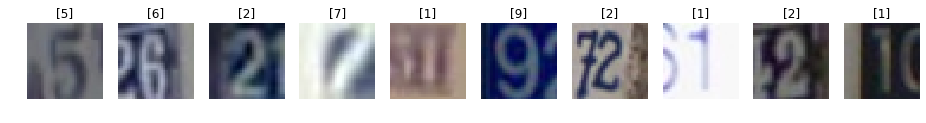

In [5]:
# selecting 10 random images from the training set and displaying them in a figure
index_imgs = list(np.random.randint(0, train_imgs.shape[0], [10]))
fig = plt.figure(figsize=(16, 16))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(train_imgs[index_imgs[i],:,:,:])
    plt.title(train_labs[index_imgs[i]])
plt.show();

In [6]:
# converting training/test images to grayscale taking the mean
train_imgs_bw = np.mean(train_imgs, axis=3)[..., np.newaxis]
test_imgs_bw = np.mean(test_imgs, axis=3)[..., np.newaxis]

In [7]:
# normalizing images
train_imgs_bw = train_imgs_bw/255
test_imgs_bw = test_imgs_bw/255

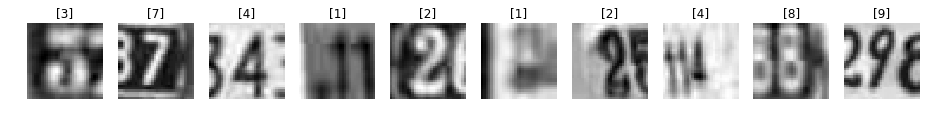

In [8]:
# selecting 10 random images from the training set and displaying them in a figure
index_imgs = list(np.random.randint(0, train_imgs_bw.shape[0], [10]))
fig = plt.figure(figsize=(16, 16))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(train_imgs_bw[index_imgs[i],:,:,:].squeeze(), cmap='gray')
    plt.title(train_labs[index_imgs[i]])
plt.show();

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
# first, we apply One Hot Encoder to our labels, to suit correctly our MLP with the final level of 10 neurons
encoder = OneHotEncoder().fit(train_labs)
train_labs_one_hot = encoder.transform(train_labs).toarray()
test_labs_one_hot = encoder.transform(test_labs).toarray()

test_labs_one_hot[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [10]:
# building model
def build_mlp_model(shape):
#     Build an MLP model with a Flatten and four Dense layer
#     in - shape: the shape of the imput of our network
#     out - model: the model we just built
    model = Sequential()
    model.add(Flatten(input_shape=shape))
    model.add(Dense(512, activation='relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)))
    model.add(Dense(64, activation='relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)))
    model.add(Dense(32, activation='relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    return model
                                 
model_mlp = build_mlp_model(train_imgs_bw[0].shape)

In [11]:
# printing out model summary
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 560,042
Trainable params: 560,042
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [13]:
# creating Tensorflow checkpoints object 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                             factor=0.5, 
                             patience=3,
                             verbose=1)
checkpoint_mlp_best_path = 'model_checkpoints_best/checkpoint_mlp'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_mlp_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [14]:
# fitting the model for 30 epochs
history = model_mlp.fit(train_imgs_bw, 
                        train_labs_one_hot,
                        epochs=30, 
                        batch_size=64,
                        callbacks=[reduce_lr, checkpoint_best],
                        validation_data=(test_imgs_bw, test_labs_one_hot))

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73088/73257 [============================>.] - ETA: 0s - loss: 2.1694 - accuracy: 0.2162
Epoch 00001: val_accuracy improved from -inf to 0.41672, saving model to model_checkpoints_best/checkpoint_mlp
73257/73257 [==============================] - 43s 587us/sample - loss: 2.1682 - accuracy: 0.2166 - val_loss: 1.7070 - val_accuracy: 0.4167
Epoch 2/30
73152/73257 [============================>.] - ETA: 0s - loss: 1.4524 - accuracy: 0.5095
Epoch 00002: val_accuracy improved from 0.41672 to 0.54510, saving model to model_checkpoints_best/checkpoint_mlp
73257/73257 [==============================] - 42s 570us/sample - loss: 1.4520 - accuracy: 0.5096 - val_loss: 1.4338 - val_accuracy: 0.5451
Epoch 3/30
73088/73257 [============================>.] - ETA: 0s - loss: 1.2043 - accuracy: 0.6134
Epoch 00003: val_accuracy improved from 0.54510 to 0.60641, saving model to model_checkpoints_best/checkpoint_mlp
73257/73257 [==================

Epoch 25/30
73088/73257 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.7989
Epoch 00025: val_accuracy improved from 0.75680 to 0.75753, saving model to model_checkpoints_best/checkpoint_mlp
73257/73257 [==============================] - 41s 563us/sample - loss: 0.6526 - accuracy: 0.7988 - val_loss: 0.8252 - val_accuracy: 0.7575
Epoch 26/30
73216/73257 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.8003
Epoch 00026: val_accuracy improved from 0.75753 to 0.75949, saving model to model_checkpoints_best/checkpoint_mlp
73257/73257 [==============================] - 43s 588us/sample - loss: 0.6503 - accuracy: 0.8003 - val_loss: 0.8239 - val_accuracy: 0.7595
Epoch 27/30
73024/73257 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.8019
Epoch 00027: val_accuracy did not improve from 0.75949
73257/73257 [==============================] - 43s 591us/sample - loss: 0.6477 - accuracy: 0.8017 - val_loss: 0.8284 - val_accuracy: 0

An MLP with around 560,000 trainable parameters, in 30 epochs, was able to reach a loss of 0.6407 (0.8146 on the validation data, but keep in mind that we didn't use any resularization technique here).
These seem good results. In the next paragraph we will see a CNN architecture that will be able to get better results in just 10 epochs.

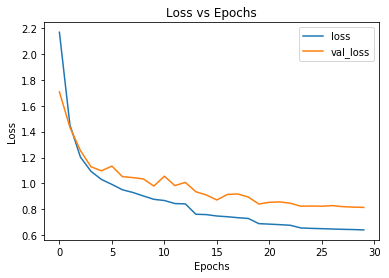

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show();

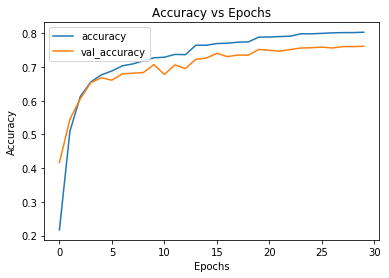

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'], loc='upper left')
plt.show();

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
# building model
def build_cnn_model():
#     Build a CNN with two convolutional + two max pooling layers, followed by two dense layers
#     out: model: the model we just built
    model = Sequential()
    model.add(Conv2D(16, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1), 
                     input_shape=(32, 32,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(16, 
                     kernel_size=(3,3), 
                     activation='relu',
                     kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

model_cnn = build_cnn_model()

In [19]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [20]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
# creating Tensorflow checkpoints object 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=3,
                              verbose=1)
checkpoint_cnn_best_path = 'model_checkpoints_best/checkpoint_cnn'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_cnn_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [23]:
# fitting the model for 10 epochs
history = model_cnn.fit(train_imgs_bw, 
                        train_labs_one_hot, 
                        epochs=10, 
                        batch_size=64,
                        callbacks=[reduce_lr, checkpoint_best],
                        validation_data=(test_imgs_bw, test_labs_one_hot))

Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73216/73257 [============================>.] - ETA: 0s - loss: 1.4459 - accuracy: 0.5177
Epoch 00001: val_accuracy improved from -inf to 0.75303, saving model to model_checkpoints_best/checkpoint_cnn
73257/73257 [==============================] - 293s 4ms/sample - loss: 1.4456 - accuracy: 0.5178 - val_loss: 1.0079 - val_accuracy: 0.7530
Epoch 2/10
73216/73257 [============================>.] - ETA: 0s - loss: 0.9003 - accuracy: 0.7142
Epoch 00002: val_accuracy improved from 0.75303 to 0.81753, saving model to model_checkpoints_best/checkpoint_cnn
73257/73257 [==============================] - 287s 4ms/sample - loss: 0.9002 - accuracy: 0.7143 - val_loss: 0.6167 - val_accuracy: 0.8175
Epoch 3/10
73216/73257 [============================>.] - ETA: 0s - loss: 0.8135 - accuracy: 0.7437
Epoch 00003: val_accuracy did not improve from 0.81753
73257/73257 [==============================] - 286s 4ms/sample - loss: 0.8135 - accuracy: 0.

The number of trainable parameters in this case is 40,122, meaning less than 1/10th of the previous model. The model has two convolutions, with batch normalizations and max poolings, then a flatten layer, followed by a dropout, and then a couple of dense layers with another dropout. the architecture is more complex than the previous one so the training is slower. Using regularization technique though, the results we reached show no variance between training and validation sets. As we can see, results from this model are worse on the training set compared the the MLP one (trained for 30 epochs, here just for 8): we passed from 0.6407 to 0.6924 (we reached this results at the end of the 8th epoch). But validation loss passes from 0.814 with the previous model to 0.4783, and this looks like a great improvement. Anyway, we will check some predictions made with both models in the 4th and final paragraph.

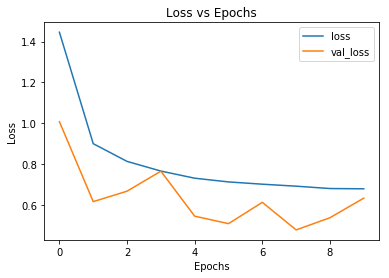

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show();

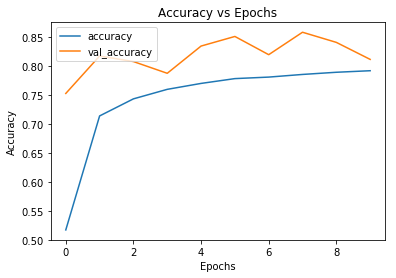

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'], loc='upper left')
plt.show();

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [26]:
best_mlp = build_mlp_model(train_imgs_bw[0].shape)
best_mlp.load_weights(checkpoint_mlp_best_path)

In [27]:
best_cnn = build_cnn_model()
best_cnn.load_weights(checkpoint_cnn_best_path)

In [55]:
# selecting 5 random images from the test set and displaying them in a figure - MLP
index_imgs = list(np.random.randint(0, test_imgs.shape[0], [5]))
predictions_mlp = model_mlp.predict(test_imgs_bw[index_imgs])
predictions_cnn = model_cnn.predict(test_imgs_bw[index_imgs])

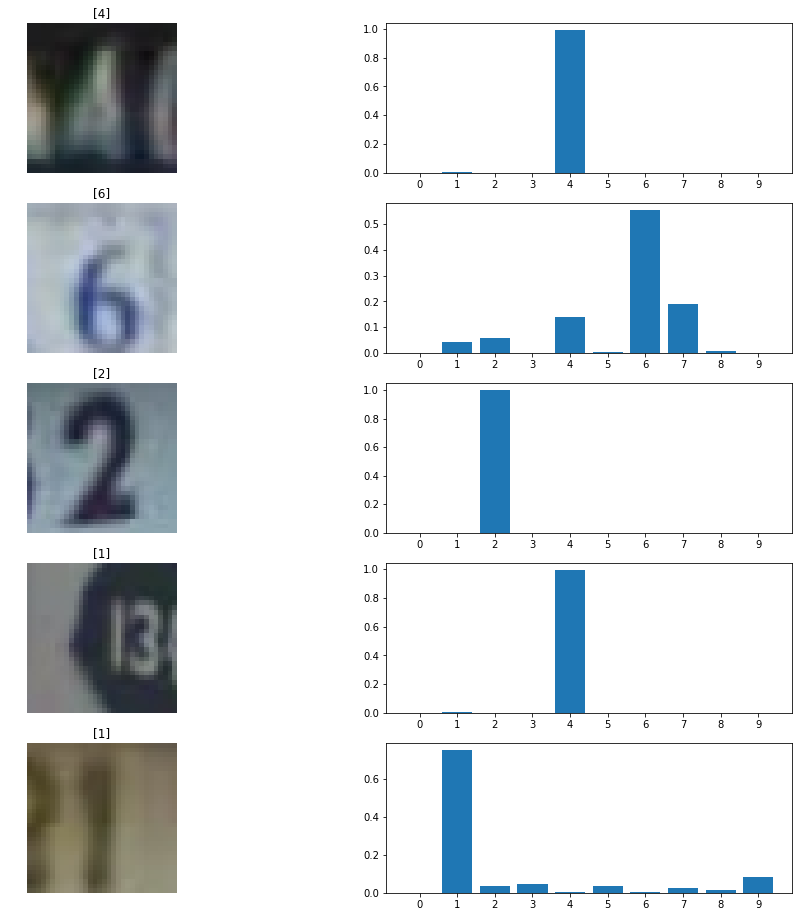

In [56]:
# showing MLP results
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(5, 2, 1+i*2)
    plt.axis('off')
    plt.imshow(test_imgs[index_imgs[i],:,:,:])
    plt.title(test_labs[index_imgs[i]]%10)
    fig.add_subplot(5, 2, (i+1)*2)
    pred = list(predictions_mlp[i])
    pred = pred[-1:] + pred[:-1]
    plt.bar(list(np.arange(10)), pred)
    plt.xticks(list(np.arange(10)))
plt.show();

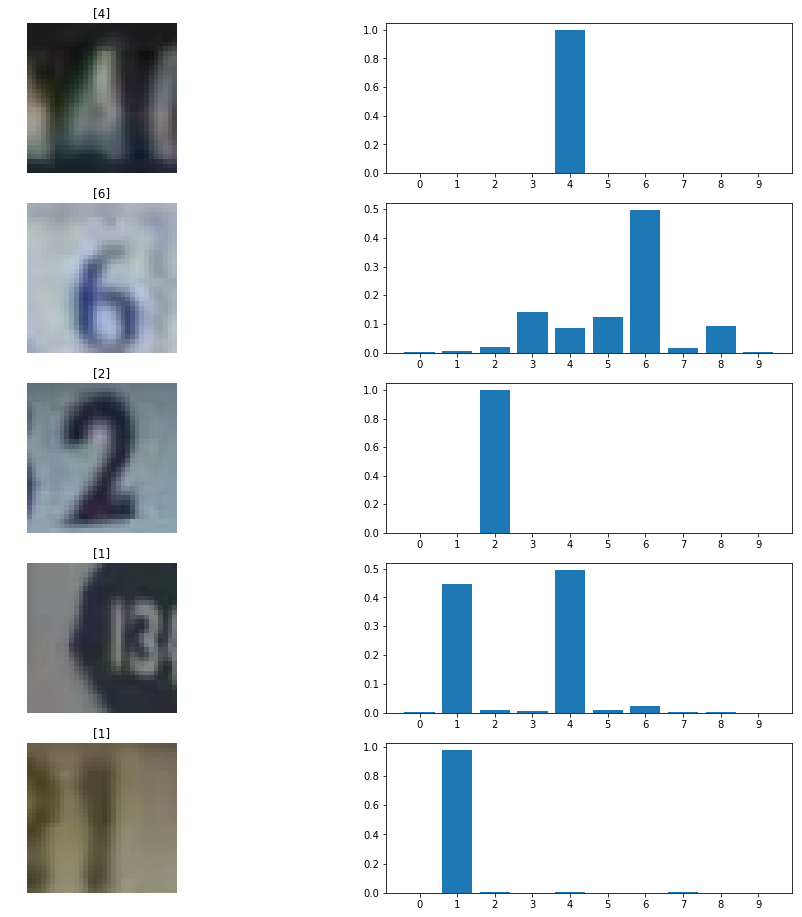

In [57]:
# showing CNN results
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(5, 2, 1+i*2)
    plt.axis('off')
    plt.imshow(test_imgs[index_imgs[i],:,:,:])
    plt.title(test_labs[index_imgs[i]]%10)
    fig.add_subplot(5, 2, (i+1)*2)
    pred = list(predictions_cnn[i])
    pred = pred[-1:] + pred[:-1]
    plt.bar(list(np.arange(10)), pred)
    plt.xticks(list(np.arange(10)))
plt.show();

Basically we reached the same results with both models. Actually even better with our MLP.